In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [2]:
df = pd.read_csv('data/cc_data_processed.csv')

In [3]:
# Use date as index
df.index = pd.to_datetime(df['Transaction Date'])
df.drop('Transaction Date', axis = 1, inplace = True, errors='ignore')
df.head()

,Account Type,Consumer Gender,Normalized Retailer,SIC Description,Purchase Amount,Age
Transaction Date,,,,,,
2019-07-01,credit_card,male,Red Robin,Eating Places,15.52,22.0
2019-09-30,bank_account,male,California Thai,Eating Places,11.29,30.0
2019-06-24,credit_card,male,Petro-Canada,Gasoline Service Stations,10.78,34.0
2018-10-01,bank_account,female,The Beer Store,Other,88.90,43.0
2019-12-01,bank_account,male,Intermarche,Grocery Stores,23.54,62.0


In [4]:
# table with transaction counts and total amount aggregated for each month
df_group = df.groupby([pd.Grouper(freq = 'M')]).agg({'Purchase Amount': {'count', 'sum'}}).rename(columns={'count':'Transaction_Count','sum':'Purchase_Sum'})
df_group.columns = df_group.columns.droplevel(0)
df_group.head()

,Transaction_Count,Purchase_Sum
Transaction Date,,
2016-04-30,12,103.81
2016-05-31,31,967.50
2016-06-30,48,1346.28
2016-07-31,58,1645.19
2016-08-31,88,2971.88


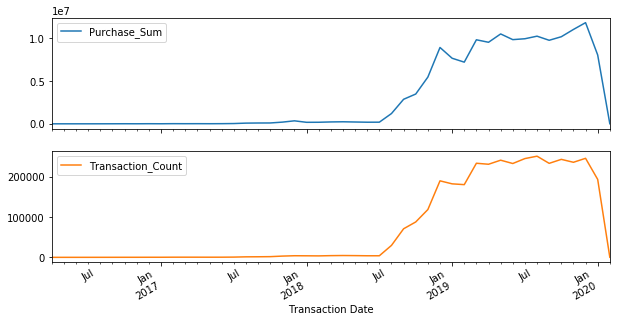

In [5]:
df_group.plot(subplots = True, y= ["Purchase_Sum","Transaction_Count"], figsize=(10,5));

                  Transaction_Count  Purchase_Sum
Transaction Date                                 
2018-09-30                    70906  2.864154e+06
2018-10-31                    87826  3.476955e+06
2018-11-30                   118630  5.455445e+06
2018-12-31                   189849  8.910758e+06
2019-01-31                   182379  7.653694e+06
2019-02-28                   180404  7.199211e+06
2019-03-31                   233468  9.809226e+06
2019-04-30                   230990  9.517425e+06
2019-05-31                   241047  1.049074e+07
2019-06-30                   232827  9.825952e+06
2019-07-31                   245095  9.930230e+06
2019-08-31                   250985  1.023078e+07
2019-09-30                   233238  9.750168e+06
2019-10-31                   243126  1.016536e+07
2019-11-30                   235863  1.101461e+07
2019-12-31                   245742  1.180695e+07
2020-01-31                   193349  8.032002e+06


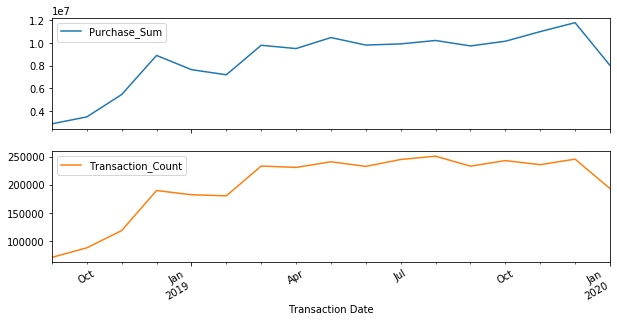

In [6]:
# only keep data from Sep 2018 to Jan 2020
df_period = df_group.loc['2018-09-01':'2020-01-31']
#df_period = df_group.loc['2018-09-01':'2019-12-31']
df_period.plot(subplots = True, y= ["Purchase_Sum","Transaction_Count"], figsize=(10,5));
print(df_period) # 17 month in total

In [7]:
# load marco economic data
df_eco = pd.read_csv('data/eco/macro_economic_data.csv')

# Extract eco data from Sep 2018 to Jan 2020
df_eco.index = pd.to_datetime(df_eco['Date'])
df_eco.drop('Date',axis = 1, inplace = True, errors='ignore')
df_eco = df_eco.loc['2018-09-01':'2020-01-31']
#df_eco = df_eco.loc['2018-09-01':'2019-12-31']

In [8]:
df_all = pd.concat([df_eco, df_period.set_index(df_eco.index)], axis=1)
df_all.head(20)

,CPI,Exchange_Rate_USD,GDP,Unemployment_Rate,TSX,Transaction_Count,Purchase_Sum
Date,,,,,,,
2018-09-01,133.7,1.3037,1948264.0,5.4,16073.14,70906,2.864154e+06
2018-10-01,134.1,1.3010,1951927.0,5.3,15027.28,87826,3.476955e+06
2018-11-01,133.5,1.3200,1947407.0,5.2,15197.82,118630,5.455445e+06
2018-12-01,133.4,1.3432,1947565.0,5.2,14322.86,189849,8.910758e+06
2019-01-01,133.6,1.3301,1950566.0,6.2,15540.60,182379,7.653694e+06
2019-02-01,134.5,1.3206,1947014.0,6.1,15999.01,180404,7.199211e+06
2019-03-01,135.4,1.3368,1959450.0,6.2,16102.09,233468,9.809226e+06
2019-04-01,136.0,1.3378,1965660.0,5.9,16580.73,230990,9.517425e+06
2019-05-01,136.6,1.3459,1971646.0,5.5,16037.49,241047,1.049074e+07


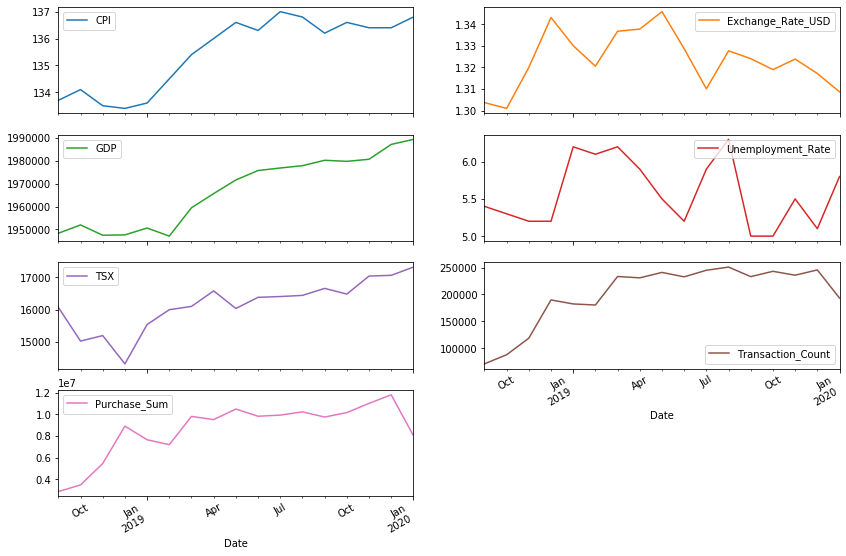

In [9]:
df_all.plot(subplots = True,figsize=(14,10),layout=(4, 2));

In [10]:
#y_train = df_all['Purchase_Sum'].values
y_train = df_all['Transaction_Count'].values

X_train = df_all[['CPI','Exchange_Rate_USD','GDP','Unemployment_Rate','TSX']]
#X_train = df_all[['CPI','Exchange_Rate_USD','GDP','TSX']]

In [11]:
# regression with sklearn
lm = LinearRegression()
lm.fit(X_train,y_train)
y_pred = lm.predict(X_train)
print("Linear regression R square: %.2f" % r2_score(y_train, y_pred))

Linear regression R square: 0.88


In [12]:
# regression with stats
X_train = sm.add_constant(X_train)
lm_stats = sm.OLS(y_train,X_train)
lm_stats.fit().summary()

d:\anaconda3\lib\site-packages\scipy\stats\stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     16.49
Date:                Thu, 05 Nov 2020   Prob (F-statistic):           8.72e-05
Time:                        17:26:43   Log-Likelihood:                -191.67
No. Observations:                  17   AIC:                             395.3
Df Residuals:                      11   BIC:                             400.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -8.342e+06   1.47e+06     -5.689      0.000   -1.16e+07   -5.11e+06
CPI                1.756e+04    1.4e+04      1.251      0.237   -1.33e+04    4.85e+04
Exchange_Rate_USD  2.189e+06   5.09e+05      4.303      0.001    1.07e+06    3.31e+06
GDP                   1.6689      1.378      1.211      0.251      -1.364       4.702
Unemployment_Rate   1.61e+04   1.66e+04      0.970      0.353   -2.04e+04    5.26e+04
TSX                  -6.5856     16.139     -0.408      0.691     -42.108      28.937
==============================================================================
Omnibus:                        1.061   Durbin-Watson:                   1.552
Prob(Omnibus):                  0.588   Jarque-Bera (JB):                0.862
Skew:                          -0.288   Prob(JB):                        0.650
Kurtosis:                       2.060   Cond. No.                     5.04e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.04e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [13]:
df_eco.head()

,CPI,Exchange_Rate_USD,GDP,Unemployment_Rate,TSX
Date,,,,,
2018-09-01,133.7,1.3037,1948264.0,5.4,16073.14
2018-10-01,134.1,1.3010,1951927.0,5.3,15027.28
2018-11-01,133.5,1.3200,1947407.0,5.2,15197.82
2018-12-01,133.4,1.3432,1947565.0,5.2,14322.86
2019-01-01,133.6,1.3301,1950566.0,6.2,15540.60


In [14]:
eco_var = 'CPI'
df_input = df_eco[eco_var].reset_index().rename(columns = {"Date": "ds", eco_var : "y"})
df_input.tail()

,ds,y
12,2019-09-01,136.2
13,2019-10-01,136.6
14,2019-11-01,136.4
15,2019-12-01,136.4
16,2020-01-01,136.8


In [15]:
m = Prophet();
m.fit(df_input);

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 12.


In [16]:
# `freq` indicates units, here we use start of the month (MS), to predict one month in future
future = m.make_future_dataframe(periods = 1, freq = "MS")
future.tail()

,ds
13,2019-10-01
14,2019-11-01
15,2019-12-01
16,2020-01-01
17,2020-02-01


In [17]:
forecast = m.predict(future)
#forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

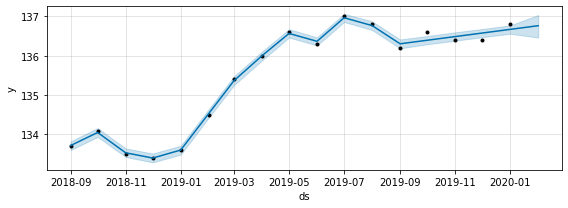

In [18]:
fig1 = m.plot(forecast, figsize=(8,3))
#fig2 = m.plot_components(forecast)